In [562]:
import cvxpy as cvx
import gurobipy as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gurobipy import GRB
from numpy import linalg as la
from scipy.sparse.csgraph import connected_components
from sklearn.datasets import make_moons
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from src.datasets import load_iris

In [563]:
X, y, labels, target = load_iris(target='Iris-virginica', without='Iris-setosa')
# X, labels = make_moons(400,noise=0.01,random_state=0)

In [761]:
C = 0.1
sigma = 2
q = 1
p = 0.1
# C = 1/(len(X)*p)
tol = 1e-4
X_indices = range(len(X))

In [762]:
def k(x, y):
    y = np.array(y)
    x, y = (np.array(arg) if type(arg) is not np.array else arg for arg in (x, y))
    numerator = -1. * (la.norm(x - y) ** 2)
    denominator = 2 * (sigma ** 2)
    return np.exp(numerator / denominator)

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def converge(n, c):
    if (n - 0) < tol:
        return 0
    elif (c - n) < tol:
        return c
    else:
        return n
    
def get_interpolated_points(x1, x2, n=5):
    points = []
    for i in range(n):
        points.append(a + (b - a) * i / (n + 1))

    return np.array(points)

In [763]:
m = gp.Model()
beta = m.addVars(X_indices, name='beta', ub=C)
m.addConstr((gp.quicksum(beta) == 1), name='sum_constraint')

first_summation = gp.quicksum(beta[j] * k(X[j], X[j]) for j in X_indices)
second_summation = gp.quicksum(
    beta[i] * beta[j] * k(X[i], X[j]) for i in X_indices for j in X_indices)
m.setObjective(first_summation - second_summation, GRB.MAXIMIZE)
m.optimize()

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 100 columns and 100 nonzeros
Model fingerprint: 0xef93b006
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e-01, 4e+00]
  Bounds range     [1e-01, 1e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 100 columns, 100 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 46
 AA' NZ     : 1.081e+03
 Factor NZ  : 1.128e+03
 Factor Ops : 3.572e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.00000731e+05  1.00052689e+04  1.00e+05 3.07e-01  1.00e+06     0s
   1   1.00838271e+02  1.00026850e+04  1.00e+

In [764]:
beta_star = np.array([converge(value.x, C) for (key, value) in beta.items()])
beta_star

array([0.09050724, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.1       , 0.        , 0.        ,
       0.1       , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.1       , 0.        ,
       0.        , 0.        , 0.        , 0.1       , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04699471, 0.06249804, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.1       , 0.1       , 0.        ,
       0.        , 0.        , 0.1       , 0.        , 0.     

In [765]:
fixed_term = sum([beta_star[i] * beta_star[j] * k(X[i], X[j]) for i in X_indices for j in X_indices])
fixed_term

0.5160769696177874

In [766]:
i, = np.where((0 < beta_star) & (beta_star < C))
i

array([ 0, 55, 56], dtype=int64)

In [773]:
[get_distance_from_center(el) for el in X[i]]

[0.5506230851768809, 0.44718239029884876]

In [767]:
def get_distance_from_center(x):
    return k(x, x) - 2 * sum([beta_star[j] * k(X[j], x) for j in X_indices]) + fixed_term

In [768]:
def get_squared_r():
    i, = np.where((0 < beta_star) & (beta_star < C))
    return np.max([get_distance_from_center(el) for el in X[i]])

In [769]:
sq_r = get_squared_r()
sq_r

0.450430667231148

In [770]:
len([get_distance_from_center(x) for x in X if get_distance_from_center(x) <= sq_r])

92

In [771]:
# [get_distance_from_center(x) for x in X]

In [772]:
A = np.zeros(shape=(len(X), len(X)))
for i, x_i in enumerate(X):
    for j, x_j in enumerate(X):
        points = get_interpolated_points(x_i, x_j)
        squared_r_inequalities = np.array([get_distance_from_center(point) <= sq_r for point in points])
        val = squared_r_inequalities.all()
        print('elements ', i, j, val, squared_r_inequalities)
        A[i][j] = A[j][i] = val

elements  0 0 True [ True  True  True  True  True]
elements  0 1 True [ True  True  True  True  True]
elements  0 2 True [ True  True  True  True  True]
elements  0 3 True [ True  True  True  True  True]
elements  0 4 True [ True  True  True  True  True]
elements  0 5 True [ True  True  True  True  True]
elements  0 6 True [ True  True  True  True  True]
elements  0 7 True [ True  True  True  True  True]
elements  0 8 True [ True  True  True  True  True]
elements  0 9 True [ True  True  True  True  True]
elements  0 10 True [ True  True  True  True  True]
elements  0 11 True [ True  True  True  True  True]
elements  0 12 True [ True  True  True  True  True]
elements  0 13 True [ True  True  True  True  True]
elements  0 14 True [ True  True  True  True  True]
elements  0 15 True [ True  True  True  True  True]
elements  0 16 True [ True  True  True  True  True]
elements  0 17 True [ True  True  True  True  True]
elements  0 18 True [ True  True  True  True  True]
elements  0 19 True [ 

elements  1 69 True [ True  True  True  True  True]
elements  1 70 True [ True  True  True  True  True]
elements  1 71 True [ True  True  True  True  True]
elements  1 72 True [ True  True  True  True  True]
elements  1 73 True [ True  True  True  True  True]
elements  1 74 True [ True  True  True  True  True]
elements  1 75 True [ True  True  True  True  True]
elements  1 76 True [ True  True  True  True  True]
elements  1 77 True [ True  True  True  True  True]
elements  1 78 True [ True  True  True  True  True]
elements  1 79 True [ True  True  True  True  True]
elements  1 80 True [ True  True  True  True  True]
elements  1 81 True [ True  True  True  True  True]
elements  1 82 True [ True  True  True  True  True]
elements  1 83 True [ True  True  True  True  True]
elements  1 84 True [ True  True  True  True  True]
elements  1 85 True [ True  True  True  True  True]
elements  1 86 True [ True  True  True  True  True]
elements  1 87 True [ True  True  True  True  True]
elements  1 

elements  3 58 True [ True  True  True  True  True]
elements  3 59 True [ True  True  True  True  True]
elements  3 60 True [ True  True  True  True  True]
elements  3 61 True [ True  True  True  True  True]
elements  3 62 True [ True  True  True  True  True]
elements  3 63 True [ True  True  True  True  True]
elements  3 64 True [ True  True  True  True  True]
elements  3 65 True [ True  True  True  True  True]
elements  3 66 True [ True  True  True  True  True]
elements  3 67 True [ True  True  True  True  True]
elements  3 68 True [ True  True  True  True  True]
elements  3 69 True [ True  True  True  True  True]
elements  3 70 True [ True  True  True  True  True]
elements  3 71 True [ True  True  True  True  True]
elements  3 72 True [ True  True  True  True  True]
elements  3 73 True [ True  True  True  True  True]
elements  3 74 True [ True  True  True  True  True]
elements  3 75 True [ True  True  True  True  True]
elements  3 76 True [ True  True  True  True  True]
elements  3 

KeyboardInterrupt: 

In [ ]:
A

In [76]:
n_components, labels = connected_components(csgraph=A, directed=False, return_labels=True)
n_components, labels

(1,
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

# Interpolation plot

In [30]:
a = X[0]
b = X[70]
a, b

(array([1.28479459, 0.68543919]), array([2.42816726, 0.37678197]))

In [39]:
extremes = np.array([a, b])
points = []
n = 10
for i in range(n):
    points.append(a + (b - a) * i / (n))

points = np.array(points)
points

array([[1.28479459, 0.68543919],
       [1.39913185, 0.65457346],
       [1.51346912, 0.62370774],
       [1.62780639, 0.59284202],
       [1.74214366, 0.5619763 ],
       [1.85648092, 0.53111058],
       [1.97081819, 0.50024486],
       [2.08515546, 0.46937914],
       [2.19949272, 0.43851341],
       [2.31382999, 0.40764769]])

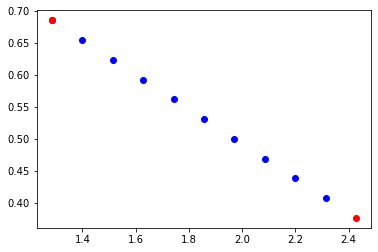

In [40]:
plt.scatter(points[:, 0], points[:, 1], c='blue')
plt.scatter(extremes[:, 0], extremes[:, 1], c='red')
plt.show()

In [16]:
# Second Phase

In [463]:
class SupportVectorClustering():
    
    def __init__(self):
        pass
    
    def dataset(self,xs):
        self.xs = xs
        self.N = len(xs)
    def parameters(self,p=0.1, q=1):
        self.p = p
        self.q = q
        self.C = 1/(self.N*p)
    def kernel(self,x1,x2):
        return np.exp(-self.q*np.sum((x1-x2)**2,axis=-1))
    def kernel_matrix(self):
        self.km=np.zeros((self.N,self.N))
        for i in range(self.N):
            for j in range(self.N):
                self.km[i,j] = self.kernel(self.xs[i],self.xs[j])
    def find_beta(self):
        '''
        beta = cvx.Variable(self.N)
        objective = cvx.Maximize(cvx.sum(beta)-cvx.quad_form(beta, self.km ))
        constraints = [0 <= beta,beta<=self.C,cvx.sum(beta)==1]
        prob = cvx.Problem(objective, constraints)
        result = prob.solve()
        self.beta = beta.value
        '''
        
        m = gp.Model()
        beta = m.addVars(self.N, name='beta', ub=self.C)
        m.addConstr((gp.quicksum(beta) == 1), name='sum_constraint')

        first_summation = gp.quicksum(beta[j] * k(X[j], X[j]) for j in X_indices)
        second_summation = gp.quicksum(
            beta[i] * beta[j] * k(X[i], X[j]) for i in X_indices for j in X_indices)
        m.setObjective(first_summation - second_summation, GRB.MAXIMIZE)
        m.optimize()
        self.beta = np.array([value.x for (key, value) in beta.items()])
        
    def r_func(self,x):
        return self.kernel(x,x)-2*np.sum([self.beta[i]*self.kernel(self.xs[i],x) for i in range(self.N)]) + self.beta.T@self.km@self.beta
    def sample_segment(self,x1,x2,r,n=10):
        adj = True
        for i in range(n):
            x = x1+(x2-x1)*i/(n+1)
            if self.r_func(x)>r:
                adj = False
                return adj
        return adj
    def cluster(self):
        svs_tmp = np.array(self.beta<self.C)*np.array(self.beta>10**-8)
        self.svs = np.where(svs_tmp==True)[0]
        bsvs_tmp = np.array(self.beta>=self.C)
        self.bsvs = np.where(bsvs_tmp==True)[0]
        self.r = np.mean([self.r_func(self.xs[i]) for i in self.svs[:5]])
        self.adj = np.zeros((self.N,self.N))
        for i in range(self.N):
            print(i)
            if i not in self.bsvs:
                for j in range(i,self.N):
                    if j not in self.bsvs:
                        self.adj[i,j]=self.adj[j,i]=self.sample_segment(self.xs[i],self.xs[j],self.r)
    def return_clusters(self):
        ids = list(range(self.N))
        self.clusters = {}
        num_clusters = 0
        while ids:
            num_clusters+=1
            self.clusters[num_clusters]=[]
            curr_id = ids.pop(0)
            queue = [curr_id]
            while queue:
                cid = queue.pop(0)
                for i in ids:
                    if self.adj[i,cid]:
                        queue.append(i)
                        ids.remove(i)
                self.clusters[num_clusters].append(cid)
            
                
    def show_plot(self):
        labels = np.zeros(self.xs.shape[0])
        for i in self.clusters.keys():
            for j in self.clusters[i]:
                labels[j] = int(i)
        
        from pandas import DataFrame
        from matplotlib import pyplot
        df = DataFrame(dict(x=self.xs[:,0], y=self.xs[:,1], label=labels))
        print(df)
        colors ={1:'r',2:'b',3:'g',4:'c',5:'m',6:'y',7:'k',8:'b',9:'c'}
        cmap = get_cmap(self.N)
        plt.figure(figsize=(8,8))
        plt.scatter(x=df['x'], y=df['y'], c=df['label'], cmap=plt.cm.Set1,
              edgecolor='k')
        plt.show()

In [464]:
svc = SupportVectorClustering()

In [507]:
svc.dataset(X)
svc.parameters(p=0.1, q=0.1)
svc.kernel_matrix()
svc.find_beta()
svc.cluster()

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 100 columns and 100 nonzeros
Model fingerprint: 0xe3b37a10
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [4e-10, 4e+00]
  Bounds range     [1e-01, 1e-01]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 100 columns, 100 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 87
 AA' NZ     : 3.828e+03
 Factor NZ  : 3.916e+03
 Factor Ops : 2.310e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   9.95008545e+04  1.01051455e+04  9.95e+04 1.35e-01  1.00e+06     0s
   1   1.00177623e+02  1.01122928e+04  9.94e+

In [508]:
svc.return_clusters()

           x         y  label
0   1.284795  0.685439    1.0
1   0.932411  0.319198    1.0
2   1.464061  0.504190    1.0
3   0.180967 -0.825604    1.0
4   1.087134  0.075390    1.0
..       ...       ...    ...
95  1.944017  0.187415    1.0
96  1.525664 -0.375021    1.0
97  1.764046  0.078519    1.0
98  1.901629  0.115877    1.0
99  1.389666 -0.282887    1.0

[100 rows x 3 columns]


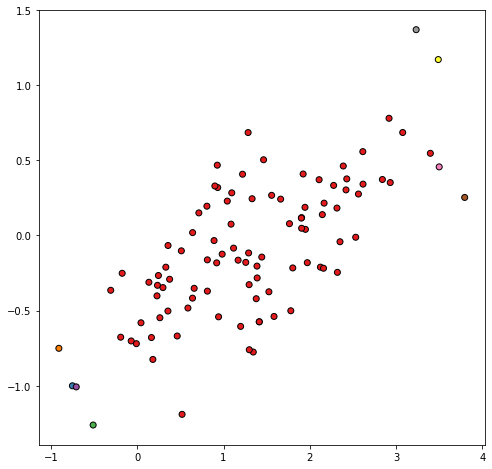

In [509]:
svc.show_plot()

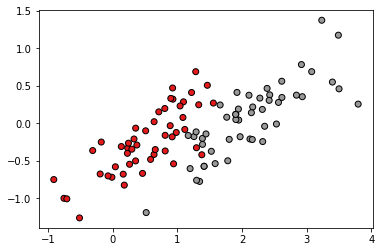

In [480]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.Set1,
              edgecolor='k')
plt.show()